
# UNet-MNIST-light: Information Bottleneck View of U-Net Compression

This notebook implements a **light U-Net** on MNIST and uses it to illustrate:

- How an encoder–decoder architecture compresses an input image into a latent representation \(Z\).
- How **compression strength** (U-Net depth / bottleneck width) affects:
  - Reconstruction quality (mean squared error).
  - The entropy of the bottleneck activations (as a proxy for the information content in \(Z\)).

We will:

1. Define a small, configurable U-Net in PyTorch.
2. Train *shallow* and *deeper* variants on an MNIST reconstruction task.
3. Visualize reconstructions for both variants.
4. Estimate the entropy of the bottleneck activations and compare it across depths.


In [1]:

import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

os.makedirs("figs", exist_ok=True)


Using device: cpu



## Data: MNIST as an Image-to-Image Task

We treat MNIST as an **autoencoding** task: the input and target are the same image.
This lets the U-Net focus on learning a compressed representation that preserves
the relevant structure for reconstruction.


In [2]:

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_subset_size = 20000
indices = np.random.RandomState(0).choice(len(train_dataset), size=train_subset_size, replace=False)
train_subset = Subset(train_dataset, indices)

batch_size = 128
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

len(train_subset), len(test_dataset)


(20000, 10000)


## A Light U-Net Architecture


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# =============================================================
# Fixed light U-Net with explicit channel bookkeeping
# =============================================================

class DoubleConvFixed(nn.Module):
    """
    Two conv-BN-ReLU layers.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class DownFixed(nn.Module):
    """
    Downscale with MaxPool2d, then DoubleConvFixed.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConvFixed(in_channels, out_channels),
        )

    def forward(self, x):
        return self.net(x)


class UpFixed(nn.Module):
    """
    Upscale with ConvTranspose2d, concat skip, then DoubleConvFixed.

    in_channels:   channels coming from previous decoder feature map
    skip_channels: channels from the corresponding encoder (skip connection)
    out_channels:  channels after fusion and DoubleConvFixed
    """
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        # Upsample decoder feature map
        self.up = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=2, stride=2
        )
        # After upsampling we concat with skip: [out_channels + skip_channels]
        self.conv = DoubleConvFixed(out_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)

        # Handle possible off-by-one spatial mismatches
        diff_y = skip.size(2) - x.size(2)
        diff_x = skip.size(3) - x.size(3)
        if diff_y != 0 or diff_x != 0:
            x = F.pad(
                x,
                [diff_x // 2, diff_x - diff_x // 2,
                 diff_y // 2, diff_y - diff_y // 2],
            )

        # Concatenate along channel dimension
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

class UNetLightFixed(nn.Module):
    """
    A light U-Net with configurable depth.

    depth = 1:
        input -> conv1 -> bottleneck -> up1 -> output

    depth = 2:
        input -> conv1 -> down1 -> conv2 -> bottleneck -> up2 -> up1 -> output

    and so on.
    """
    def __init__(self, in_channels=1, out_channels=1, base_channels=16, depth=1):
        super().__init__()
        self.depth = depth
        
        # Initial encoder block
        self.inc = DoubleConvFixed(in_channels, base_channels)

        # Encoder (down) path
        self.down_blocks = nn.ModuleList()
        encoder_channels = [base_channels]  # channels after each encoder block

        ch = base_channels
        for _ in range(depth - 1):
            self.down_blocks.append(DownFixed(ch, ch * 2))
            ch *= 2
            encoder_channels.append(ch)

        # Bottleneck: one more doubling
        self.bottleneck = DoubleConvFixed(ch, ch * 2)
        bottleneck_channels = ch * 2

        # Decoder (up) path: walk encoder_channels in reverse order
        self.up_blocks = nn.ModuleList()
        decoder_in_channels = bottleneck_channels

        for skip_ch in reversed(encoder_channels):
            out_ch = skip_ch  # after fusion we go back to skip size
            self.up_blocks.append(
                UpFixed(
                    in_channels=decoder_in_channels,
                    skip_channels=skip_ch,
                    out_channels=out_ch,
                )
            )
            decoder_in_channels = out_ch

        # Final 1x1 conv to map to desired output channels
        self.outc = nn.Conv2d(decoder_in_channels, out_channels, kernel_size=1)
        self.inc = DoubleConvFixed(in_channels, base_channels)

    def forward(self, x):
        # Encoder: store skips
        skips = []
        x_enc = self.inc(x)
        skips.append(x_enc)

        for down in self.down_blocks:
            x_enc = down(x_enc)
            skips.append(x_enc)

        # Bottleneck
        x_dec = self.bottleneck(x_enc)
        # store bottleneck activations for later entropy analysis
        self._last_bottleneck = x_dec

        # Decoder: use skips from deepest to shallowest
        for i, up in enumerate(self.up_blocks):
            skip = skips[-(i + 1)]  # last skip first
            x_dec = up(x_dec, skip)

        x_out = self.outc(x_dec)

        # Ensure output is 28x28 (MNIST)
        if x_out.size(2) != 28 or x_out.size(3) != 28:
            x_out = F.interpolate(x_out, size=(28, 28),
                                  mode="bilinear", align_corners=False)
        return x_out

    def get_bottleneck_activations(self):
        """Return bottleneck activations from the last forward pass."""
        if hasattr(self, '_last_bottleneck'):
            return self._last_bottleneck
        return None


In [4]:

def train_unet(model, train_loader, num_epochs=5, lr=1e-3):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            x_hat = model(x)
            loss = criterion(x_hat, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} - train MSE: {avg_loss:.4f}")
    return model


def show_reconstructions(model, data_loader, n_images=8, title="Reconstructions", savepath=None):
    model.eval()
    model.to(device)
    images = []
    reconstructions = []
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.to(device)
            x_hat = model(x)
            images = x[:n_images].cpu()
            reconstructions = x_hat[:n_images].cpu()
            break

    n = images.size(0)
    fig, axes = plt.subplots(2, n, figsize=(1.5*n, 3))
    for i in range(n):
        axes[0, i].imshow(images[i, 0].numpy(), cmap="gray")
        axes[0, i].axis("off")
        axes[0, i].set_title("Input" if i == 0 else "")
        axes[1, i].imshow(reconstructions[i, 0].numpy(), cmap="gray")
        axes[1, i].axis("off")
        axes[1, i].set_title("Recon" if i == 0 else "")
    fig.suptitle(title)
    fig.tight_layout()
    if savepath is not None:
        fig.savefig(savepath, dpi=150, bbox_inches="tight")
        print(f"Saved figure to {savepath}")
    plt.show()


In [5]:
def estimate_entropy_from_tensor(z, n_bins=64, eps=1e-12):
    """Estimate (scalar) entropy H(Z) in bits from a tensor of activations.

    We simply pool all coordinates together, build a 1D histogram, and
    compute the discrete entropy of the resulting empirical distribution.
    """
    z_np = z.detach().cpu().numpy().ravel()
    hist, _ = np.histogram(z_np, bins=n_bins, density=False)
    total = hist.sum()
    if total == 0:
        return 0.0
    p = hist.astype(np.float64) / total
    p = p[p > 0]
    entropy_bits = -np.sum(p * np.log2(p))
    return entropy_bits


def collect_bottleneck_activations(model, data_loader, max_batches=50):
    """Collect bottleneck activations using the model's get_bottleneck_activations method."""
    model.eval()
    # The global 'device' is already set (e.g., 'cpu' or 'cuda')
    model.to(device) 
    activations = []
    with torch.no_grad():
        for i, (x, _) in enumerate(data_loader):
            x = x.to(device)
            _ = model(x)
            z = model.get_bottleneck_activations()
            if z is not None:
                activations.append(z.cpu())
            if i + 1 >= max_batches:
                break
    if not activations:
        return None
    return torch.cat(activations, dim=0)


def estimate_entropy(model, data_loader, max_batches=50, n_bins=64):
    """Wrapper to collect activations and estimate entropy."""
    z_all = collect_bottleneck_activations(model, data_loader, max_batches=max_batches)
    if z_all is None or z_all.numel() == 0:
        return 0.0
    return estimate_entropy_from_tensor(z_all, n_bins=n_bins)


In [6]:
# =======================================================================
# MODIFIED PARAMETERS FOR DRAMATIC COMPRESSION EFFECT
# =======================================================================
depth_shallow = 1
depth_deep = 3          # *** Increased Depth (Stronger Compression) ***
base_channels = 16
num_epochs = 10         # *** Increased Epochs (Full Convergence) ***
# =======================================================================

print(f"Training shallow U-Net (depth = {depth_shallow})")
unet_shallow = UNetLightFixed(
    in_channels=1, out_channels=1,
    base_channels=base_channels, depth=depth_shallow
)
unet_shallow = train_unet(unet_shallow, train_loader,
                          num_epochs=num_epochs, lr=1e-3)

print(f"\nTraining deeper U-Net (depth = {depth_deep})")
unet_deep = UNetLightFixed(
    in_channels=1, out_channels=1,
    base_channels=base_channels, depth=depth_deep
)
unet_deep = train_unet(unet_deep, train_loader,
                       num_epochs=num_epochs, lr=1e-3)

Training shallow U-Net (depth = 1)
Epoch 1/10 - train MSE: 0.0045
Epoch 2/10 - train MSE: 0.0006
Epoch 3/10 - train MSE: 0.0004
Epoch 4/10 - train MSE: 0.0003
Epoch 5/10 - train MSE: 0.0002
Epoch 6/10 - train MSE: 0.0002
Epoch 7/10 - train MSE: 0.0002
Epoch 8/10 - train MSE: 0.0001
Epoch 9/10 - train MSE: 0.0001
Epoch 10/10 - train MSE: 0.0001

Training deeper U-Net (depth = 3)
Epoch 1/10 - train MSE: 0.0070
Epoch 2/10 - train MSE: 0.0007
Epoch 3/10 - train MSE: 0.0004
Epoch 4/10 - train MSE: 0.0003
Epoch 5/10 - train MSE: 0.0002
Epoch 6/10 - train MSE: 0.0002
Epoch 7/10 - train MSE: 0.0002
Epoch 8/10 - train MSE: 0.0001
Epoch 9/10 - train MSE: 0.0001
Epoch 10/10 - train MSE: 0.0001


Saved figure to figs/unet_reconstruction_comparison.png


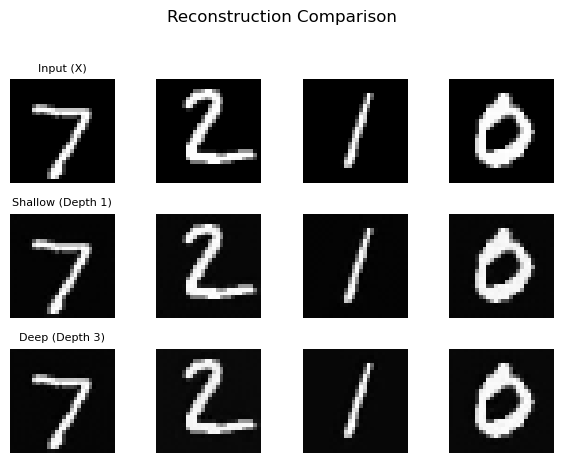

In [7]:
def show_comparison_reconstructions(model_shallow, model_deep, data_loader, n_images=4, title="Reconstruction Comparison"):
    """Shows input, shallow recon, and deep recon in a single figure."""
    model_shallow.eval()
    model_deep.eval()
    model_shallow.to(device)
    model_deep.to(device)
    
    images = []
    shallow_recons = []
    deep_recons = []
    
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.to(device)
            shallow_hat = model_shallow(x)
            deep_hat = model_deep(x)
            
            images = x[:n_images].cpu()
            shallow_recons = shallow_hat[:n_images].cpu()
            deep_recons = deep_hat[:n_images].cpu()
            break
            
    n = images.size(0)
    fig, axes = plt.subplots(3, n, figsize=(1.5*n, 4.5)) # 3 rows
    
    for i in range(n):
        # Row 1: Input
        axes[0, i].imshow(images[i, 0].numpy(), cmap="gray")
        axes[0, i].axis("off")
        if i == 0: axes[0, i].set_title("Input (X)", fontsize=8)
        
        # Row 2: Shallow
        axes[1, i].imshow(shallow_recons[i, 0].numpy(), cmap="gray")
        axes[1, i].axis("off")
        if i == 0: axes[1, i].set_title(f"Shallow (Depth {model_shallow.depth})", fontsize=8)

        # Row 3: Deep
        axes[2, i].imshow(deep_recons[i, 0].numpy(), cmap="gray")
        axes[2, i].axis("off")
        if i == 0: axes[2, i].set_title(f"Deep (Depth {model_deep.depth})", fontsize=8)

    fig.suptitle(title, y=1.02)
    fig.tight_layout()
    savepath = "figs/unet_reconstruction_comparison.png"
    fig.savefig(savepath, dpi=150, bbox_inches="tight")
    print(f"Saved figure to {savepath}")
    plt.show()

# Replace the two separate calls with this single call
show_comparison_reconstructions(unet_shallow, unet_deep, test_loader)

/var/folders/s5/8pby83n5305c0l0dvb7d7p5c0000gr/T/ipykernel_88061/2288669313.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])


Saved figure to figs/unet_error_maps.png


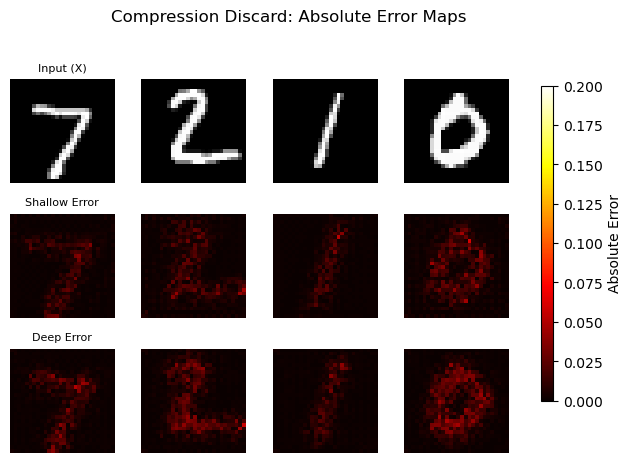

In [8]:
def show_error_maps(model_shallow, model_deep, data_loader, n_images=4):
    """Shows input and the absolute error map for both models."""
    model_shallow.eval()
    model_deep.eval()
    model_shallow.to(device)
    model_deep.to(device)

    images = []
    shallow_errors = []
    deep_errors = []

    with torch.no_grad():
        for x, _ in data_loader:
            x = x.to(device)
            shallow_hat = model_shallow(x)
            deep_hat = model_deep(x)
            
            # Calculate Absolute Error: |Input - Reconstruction|
            shallow_err = torch.abs(x - shallow_hat)
            deep_err = torch.abs(x - deep_hat)

            images = x[:n_images].cpu()
            shallow_errors = shallow_err[:n_images].cpu()
            deep_errors = deep_err[:n_images].cpu()
            break
            
    n = images.size(0)
    # We use a color map (hot) for error to make differences visually loud
    fig, axes = plt.subplots(3, n, figsize=(1.5*n, 4.5)) 
    
    for i in range(n):
        # Row 1: Input
        axes[0, i].imshow(images[i, 0].numpy(), cmap="gray")
        axes[0, i].axis("off")
        if i == 0: axes[0, i].set_title("Input (X)", fontsize=8)

        # Row 2: Shallow Error
        im_s = axes[1, i].imshow(shallow_errors[i, 0].numpy(), cmap="hot", vmin=0, vmax=0.2)
        axes[1, i].axis("off")
        if i == 0: axes[1, i].set_title(f"Shallow Error", fontsize=8)

        # Row 3: Deep Error
        im_d = axes[2, i].imshow(deep_errors[i, 0].numpy(), cmap="hot", vmin=0, vmax=0.2)
        axes[2, i].axis("off")
        if i == 0: axes[2, i].set_title(f"Deep Error", fontsize=8)
    
    # Add a single color bar for the error maps
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # [left, bottom, width, height]
    fig.colorbar(im_d, cax=cbar_ax, label='Absolute Error')

    fig.suptitle("Compression Discard: Absolute Error Maps", y=1.02)
    fig.tight_layout(rect=[0, 0, 0.9, 1])
    savepath = "figs/unet_error_maps.png"
    fig.savefig(savepath, dpi=150, bbox_inches="tight")
    print(f"Saved figure to {savepath}")
    plt.show()

# Run this new function
show_error_maps(unet_shallow, unet_deep, test_loader)


### Summary

- The **contracting path** of the U-Net compresses the image into a latent code \(Z\).
- Increasing depth typically yields **better reconstructions**, but also changes the entropy \(H(Z)\) of the bottleneck.
- The entropy estimates here are rough, but they illustrate how architectural choices implicitly control the information content of internal representations, echoing the **information bottleneck** perspective.
